# 🚀 โครงสร้างโปรเจกต์ตามมาตรฐาน CRISP-DM

# Phase 1: Business Understanding

📌 Cell 1 (Markdown) — นิยามปัญหาและเป้าหมายโครงการ
## Problem Statement
การวิเคราะห์พฤติกรรมราคาหุ้นเพื่อระบุช่วงตลาด:
- Normal (ปกติ)
- Accumulation (โซนสะสม)
- Distribution (โซนกระจายของ)

โดยใช้แนวคิด Wyckoff + Technical Indicators และ Machine Learning (XGBoost)

## Objectives
1) สร้างระบบจำแนกโซนตลาด 3 คลาสจากข้อมูลแท่งเทียน (OHLCV)
2) ตรวจจับเหตุการณ์สำคัญตาม Wyckoff เช่น SC, BC, AR, SPRING
3) สร้างฟีเจอร์ทางเทคนิค และทำ Labeling แบบ Voting
4) ฝึกโมเดล XGBoost และประเมินผลด้วย Accuracy, F1-score, Confusion Matrix

## Expected Output
- Classification Report
- Confusion Matrix
- Feature Importance
- Dashboard Visualization (Wyckoff Zones)


# Phase 2: Data Understanding

📌 Cell 1 — Cassandra + Load Data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import seaborn as sns

from cassandra.cluster import Cluster
from xgboost import XGBClassifier

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. Configuration
# ========================================
CASSANDRA_HOST = '127.0.0.1'
CASSANDRA_PORT = 9042
SYMBOL = 'CPALL'




In [19]:
# ========================================
# 2. Data Loading
# ========================================
def get_data(symbol):
    try:
        cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
        session = cluster.connect('data_stock')
        query = f"""
        SELECT symbol, time, open, high, low, close, volume
        FROM candlestick_data
        WHERE symbol = '{symbol}'
        LIMIT 3000 ALLOW FILTERING
        """
        df = pd.DataFrame(list(session.execute(query)))
        df['time'] = pd.to_datetime(df['time'])
        df.sort_values('time', inplace=True)
        cluster.shutdown()
        print(f"✅ Successfully loaded {len(df)} records for {symbol}")
        return df.reset_index(drop=True)
    except Exception as e:
        print(f"❌ Connection Error: {e}")
        return None

df = get_data(SYMBOL)
df.head()

✅ Successfully loaded 729 records for CPALL


,symbol,time,open,high,low,close,volume
0,CPALL,2023-01-17,68.00,69.00,68.00,68.75,27991828
1,CPALL,2023-01-18,68.75,68.75,67.75,68.50,47307718
2,CPALL,2023-01-19,68.50,68.75,68.25,68.75,19449645
3,CPALL,2023-01-20,68.50,68.50,67.25,68.00,24655509
4,CPALL,2023-01-23,68.50,69.50,68.50,69.25,22388807


📌 Cell 2 — สำรวจข้อมูลเบื้องต้น (info, describe, isnull)

In [32]:
print("SHAPE:", df.shape)
print("\nINFO:")
display(df.info())




SHAPE: (729, 7)

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  729 non-null    object        
 1   time    729 non-null    datetime64[ns]
 2   open    729 non-null    float64       
 3   high    729 non-null    float64       
 4   low     729 non-null    float64       
 5   close   729 non-null    float64       
 6   volume  729 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 40.0+ KB


None

In [33]:
print("\nDESCRIBE:")
display(df.describe(include='all'))




DESCRIBE:


,symbol,time,open,high,low,close,volume
count,729,729,729.000000,729.000000,729.000000,729.000000,7.290000e+02
unique,1,NaN,NaN,NaN,NaN,NaN,NaN
top,CPALL,NaN,NaN,NaN,NaN,NaN,NaN
freq,729,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2024-07-15 12:56:17.777777664,55.970508,56.510974,55.357682,55.913237,2.905420e+07
min,NaN,2023-01-17 00:00:00,40.750000,41.750000,40.500000,41.000000,3.908258e+06
25%,NaN,2023-10-16 00:00:00,50.250000,51.000000,49.500000,50.000000,1.779407e+07
50%,NaN,2024-07-16 00:00:00,56.250000,56.750000,55.500000,56.250000,2.456741e+07
75%,NaN,2025-04-11 00:00:00,62.500000,63.000000,61.750000,62.250000,3.425215e+07
max,NaN,2026-01-16 00:00:00,70.000000,70.250000,69.250000,70.000000,1.835202e+08


In [34]:
print("\nMISSING VALUES:")
display(df.isnull().sum())

print("\nDUPLICATES:", df.duplicated().sum())


MISSING VALUES:


symbol    0
time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


DUPLICATES: 0


# ✅ Phase 3: Data Preparation

ในโปรเจคของคุณ “ไม่มี categorical” จริง ๆ เพราะเป็น OHLCV + indicator
ดังนั้น Cell นี้จะเน้น cleaning + feature engineering + labeling ตามโค้ดคุณ

📌 Cell 1 (Label) — Feature + Wyckoff + Labeling

In [22]:
# ========================================
# 3. Advanced Technical Indicators
# ========================================
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period).mean()
    loss = (-delta.clip(upper=0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))

def calculate_macd(series):
    ema_12 = series.ewm(span=12).mean()
    ema_26 = series.ewm(span=26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9).mean()
    histogram = macd - signal
    return macd, signal, histogram

def calculate_bbands(series, period=20):
    ema = series.ewm(span=period).mean()
    std = series.rolling(period).std()
    upper = ema + (2 * std)
    lower = ema - (2 * std)
    bb_position = (series - lower) / (upper - lower + 1e-10)
    bb_width = (upper - lower) / (ema + 1e-10)
    return bb_position, bb_width

def calculate_stochastic(df, period=14):
    low_min = df['low'].rolling(period).min()
    high_max = df['high'].rolling(period).max()
    k = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-10)
    d = k.rolling(3).mean()
    return k, d

def calculate_obv(df):
    obv = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    return obv

def calculate_mfi(df, period=14):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']

    positive_flow = pd.Series(0.0, index=df.index)
    negative_flow = pd.Series(0.0, index=df.index)

    positive_flow[typical_price > typical_price.shift(1)] = money_flow[typical_price > typical_price.shift(1)]
    negative_flow[typical_price < typical_price.shift(1)] = money_flow[typical_price < typical_price.shift(1)]

    mfr = positive_flow.rolling(period).sum() / (negative_flow.rolling(period).sum() + 1e-10)
    mfi = 100 - (100 / (1 + mfr))
    return mfi

In [23]:
# ========================================
# 4. Wyckoff Event Detection
# ========================================
def detect_wyckoff_events(df, window=30):
    df = df.copy()

    df['price_spread'] = df['high'] - df['low']

    df['vol_ma'] = df['volume'].rolling(window=window).mean()
    df['vol_std'] = df['volume'].rolling(window=window).std()

    df['SC'] = (
        (df['volume'] > df['vol_ma'] * 2.5) &
        (df['low'] == df['low'].rolling(window).min()) &
        (df['close'] < df['open'])
    )

    df['BC'] = (
        (df['volume'] > df['vol_ma'] * 2.5) &
        (df['high'] == df['high'].rolling(window).max()) &
        (df['close'] > df['open'])
    )

    df['AR'] = False
    for i in df.index[df['SC'] | df['BC']]:
        if i + 10 < len(df):
            if df.loc[i, 'SC']:
                ar_idx = df.loc[i:i+10, 'high'].idxmax()
            else:
                ar_idx = df.loc[i:i+10, 'low'].idxmin()
            df.at[ar_idx, 'AR'] = True

    support = df['low'].rolling(window=60).min().shift(1)
    df['SPRING'] = (
        (df['low'] < support) &
        (df['close'] > support) &
        (df['volume'] > df['vol_ma']) &
        (df['close'] > df['open'])
    )

    return df

In [24]:
# ========================================
# 5. Advanced Feature Engineering (NO SMA)
# ========================================
def create_advanced_features(df):
    df = df.copy()

    if 'price_spread' not in df.columns:
        df['price_spread'] = df['high'] - df['low']

    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['high_low_ratio'] = df['high'] / (df['low'] + 1e-10)
    df['close_open_ratio'] = df['close'] / (df['open'] + 1e-10)

    for period in [5, 10, 20, 30]:
        df[f'volume_ma_{period}'] = df['volume'].rolling(period).mean()
        df[f'volume_ratio_{period}'] = df['volume'] / (df[f'volume_ma_{period}'] + 1e-10)

    df['volume_momentum'] = df['volume'].pct_change(5)
    df['volume_acceleration'] = df['volume'].pct_change(5).diff()

    for period in [5, 10, 20, 50, 100]:
        df[f'ema_{period}'] = df['close'].ewm(span=period).mean()
        df[f'price_to_ema_{period}'] = df['close'] / (df[f'ema_{period}'] + 1e-10)
        df[f'dist_from_ema_{period}'] = (df['close'] - df[f'ema_{period}']) / (df[f'ema_{period}'] + 1e-10)

    df['rsi'] = calculate_rsi(df['close'], 14)
    df['rsi_slope'] = df['rsi'].diff(5)
    df['rsi_overbought'] = (df['rsi'] > 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] < 30).astype(int)

    df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(df['close'])
    df['macd_cross'] = ((df['macd'] > df['macd_signal']).astype(int) -
                        (df['macd'] < df['macd_signal']).astype(int))

    df['stoch_k'], df['stoch_d'] = calculate_stochastic(df)
    df['bb_position'], df['bb_width'] = calculate_bbands(df['close'])

    df['obv'] = calculate_obv(df)
    df['obv_slope'] = df['obv'].diff(5)
    df['mfi'] = calculate_mfi(df, 14)

    for period in [5, 10, 20]:
        df[f'volatility_{period}'] = df['returns'].rolling(period).std()
        df[f'atr_{period}'] = df['price_spread'].rolling(period).mean()

    df['body'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['close', 'open']].max(axis=1)
    df['lower_shadow'] = df[['close', 'open']].min(axis=1) - df['low']
    df['body_pct'] = df['body'] / (df['price_spread'] + 1e-10)
    df['upper_shadow_pct'] = df['upper_shadow'] / (df['price_spread'] + 1e-10)
    df['lower_shadow_pct'] = df['lower_shadow'] / (df['price_spread'] + 1e-10)

    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close'].diff(period)
        df[f'roc_{period}'] = df['close'].pct_change(period)

    df['price_above_ema20'] = (df['close'] > df['ema_20']).astype(int)
    df['price_above_ema50'] = (df['close'] > df['ema_50']).astype(int)
    df['ema_trend'] = ((df['ema_20'] > df['ema_50']).astype(int) -
                       (df['ema_20'] < df['ema_50']).astype(int))

    if 'vol_ma' not in df.columns:
        df['vol_ma'] = df['volume'].rolling(30).mean()

    df['volume_spike'] = (df['volume'] > df['vol_ma'] * 2).astype(int)
    df['price_at_low'] = (df['close'] == df['low'].rolling(30).min()).astype(int)
    df['price_at_high'] = (df['close'] == df['high'].rolling(30).max()).astype(int)

    return df

In [25]:
# ========================================
# 6. Smart Target Labeling (Voting) (NO SMA)
# ========================================
def create_smart_targets(df):
    df = df.copy()
    df['target'] = 0

    volume_high = df['volume_ratio_30'] > df['volume_ratio_30'].quantile(0.70)

    price_low = df['close'] < df['ema_50']
    price_high = df['close'] > df['ema_50']

    rsi_oversold = df['rsi'] < 40
    rsi_overbought = df['rsi'] > 60

    mfi_oversold = df['mfi'] < 35
    mfi_overbought = df['mfi'] > 65

    bb_low = df['bb_position'] < 0.25
    bb_high = df['bb_position'] > 0.75

    stoch_oversold = df['stoch_k'] < 20
    stoch_overbought = df['stoch_k'] > 80

    macd_bullish = (df['macd'] > df['macd_signal']) & (df['macd_hist'] > 0)
    macd_bearish = (df['macd'] < df['macd_signal']) & (df['macd_hist'] < 0)

    accum_votes = (
        (price_low & volume_high).astype(int) +
        rsi_oversold.astype(int) +
        mfi_oversold.astype(int) +
        bb_low.astype(int) +
        stoch_oversold.astype(int) +
        macd_bullish.astype(int) +
        (df['close'] > df['open']).astype(int)
    )

    dist_votes = (
        (price_high & volume_high).astype(int) +
        rsi_overbought.astype(int) +
        mfi_overbought.astype(int) +
        bb_high.astype(int) +
        stoch_overbought.astype(int) +
        macd_bearish.astype(int) +
        (df['close'] < df['open']).astype(int)
    )

    df.loc[accum_votes >= 3, 'target'] = 1
    df.loc[dist_votes >= 3, 'target'] = 2

    conflicts = (accum_votes >= 3) & (dist_votes >= 3)
    df.loc[conflicts & (accum_votes > dist_votes), 'target'] = 1
    df.loc[conflicts & (dist_votes > accum_votes), 'target'] = 2

    print("\n" + "="*80)
    print("TARGET DISTRIBUTION (Voting System)")
    print("="*80)
    target_counts = df['target'].value_counts().sort_index()
    for label, count in target_counts.items():
        pct = (count / len(df)) * 100
        label_name = ['Normal', 'Accumulation', 'Distribution'][label]
        print(f"{label_name:15} : {count:5} ({pct:6.2f}%)")

    return df

In [26]:
# ---- RUN PREP ----
df_wyckoff = detect_wyckoff_events(df)
df_features = create_advanced_features(df_wyckoff)
df_labeled = create_smart_targets(df_features)

df_labeled.head()


TARGET DISTRIBUTION (Voting System)
Normal          :   368 ( 50.48%)
Accumulation    :   227 ( 31.14%)
Distribution    :   134 ( 18.38%)


,symbol,time,open,high,low,close,volume,price_spread,vol_ma,vol_std,...,roc_10,momentum_20,roc_20,price_above_ema20,price_above_ema50,ema_trend,volume_spike,price_at_low,price_at_high,target
0,CPALL,2023-01-17,68.00,69.00,68.00,68.75,27991828,1.00,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,CPALL,2023-01-18,68.75,68.75,67.75,68.50,47307718,1.00,NaN,NaN,...,NaN,NaN,NaN,0,0,-1,0,0,0,0
2,CPALL,2023-01-19,68.50,68.75,68.25,68.75,19449645,0.50,NaN,NaN,...,NaN,NaN,NaN,1,1,1,0,0,0,0
3,CPALL,2023-01-20,68.50,68.50,67.25,68.00,24655509,1.25,NaN,NaN,...,NaN,NaN,NaN,0,0,-1,0,0,0,0
4,CPALL,2023-01-23,68.50,69.50,68.50,69.25,22388807,1.00,NaN,NaN,...,NaN,NaN,NaN,1,1,1,0,0,0,0


📌 Cell 2 (Scale) — Feature Scaling (RobustScaler ตามโค้ดคุณ)

In [27]:
# เตรียม feature columns
feature_cols = [col for col in df_labeled.columns if col not in [
    'symbol', 'time', 'target', 'zone_pred',
    'SC', 'BC', 'AR', 'SPRING'
] and not df_labeled[col].isnull().all()]

X = df_labeled[feature_cols].fillna(0)
y = df_labeled['target']

X = X.replace([np.inf, -np.inf], 0)

scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)


X_scaled shape: (729, 76)
y shape: (729,)


✅ Phase 4: Modeling

📌 Cell 1 — Split + Train Model (fit)

In [28]:
split_idx = int(len(X_scaled) * 0.85)

X_train = X_scaled.iloc[:split_idx]
X_test  = X_scaled.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=3,
    early_stopping_rounds=20,
    verbosity=0
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# เก็บผลทำนายลง df
df_labeled['zone_pred'] = model.predict(X_scaled)

print("✅ Model training completed!")


Training samples: 619
Testing samples: 110
✅ Model training completed!


✅ Phase 5: Evaluation

📌 Cell 1 — Accuracy + F1 + Report + สรุปผลตอบโจทย์ธุรกิจ

In [29]:
train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, y_pred)
test_f1   = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)
print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing Accuracy:    {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"F1 Score (Weighted): {test_f1:.4f}")
print(f"Overfitting Gap:     {(train_acc - test_acc)*100:.2f}%")

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(
    y_test, y_pred,
    target_names=['Normal', 'Accumulation', 'Distribution'],
    digits=4
))

print("\n" + "="*80)
print("BUSINESS SUMMARY")
print("="*80)
print("โมเดลสามารถจำแนกโซนตลาด 3 ประเภทได้จากข้อมูลแท่งเทียน (OHLCV)")
print("- Normal: สภาวะตลาดทั่วไป")
print("- Accumulation: โซนสะสม (ใช้เป็นสัญญาณสะสม/เตรียมขึ้น)")
print("- Distribution: โซนกระจายของ (ใช้เป็นสัญญาณระวัง/เตรียมลง)")
print("ผลลัพธ์ที่ได้ช่วยสนับสนุนการตัดสินใจเชิงกลยุทธ์และการวิเคราะห์เชิงวิจัย")



MODEL EVALUATION
Training Accuracy:   1.0000 (100.00%)
Testing Accuracy:    0.9091 (90.91%)
F1 Score (Weighted): 0.9096
Overfitting Gap:     9.09%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal     0.9500    0.9048    0.9268        63
Accumulation     0.8421    0.9412    0.8889        34
Distribution     0.9167    0.8462    0.8800        13

    accuracy                         0.9091       110
   macro avg     0.9029    0.8974    0.8986       110
weighted avg     0.9127    0.9091    0.9096       110


BUSINESS SUMMARY
โมเดลสามารถจำแนกโซนตลาด 3 ประเภทได้จากข้อมูลแท่งเทียน (OHLCV)
- Normal: สภาวะตลาดทั่วไป
- Accumulation: โซนสะสม (ใช้เป็นสัญญาณสะสม/เตรียมขึ้น)
- Distribution: โซนกระจายของ (ใช้เป็นสัญญาณระวัง/เตรียมลง)
ผลลัพธ์ที่ได้ช่วยสนับสนุนการตัดสินใจเชิงกลยุทธ์และการวิเคราะห์เชิงวิจัย


✅ Phase 6: Visualization

📌 Cell 1 — Confusion Matrix + Feature Importance

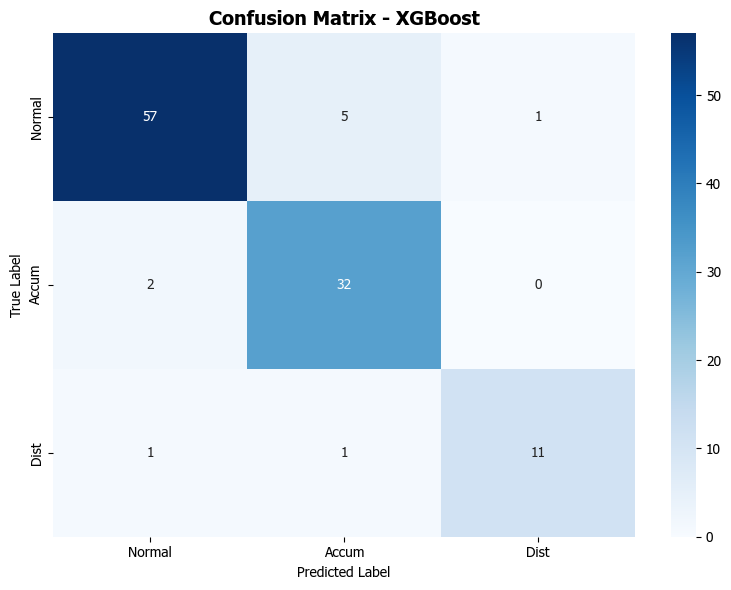


TOP 15 MOST IMPORTANT FEATURES


,feature,importance
30,dist_from_ema_20,0.131954
29,price_to_ema_20,0.114938
37,rsi,0.101966
32,price_to_ema_50,0.026549
26,price_to_ema_10,0.024995
51,mfi,0.022643
33,dist_from_ema_50,0.020053
19,volume_ratio_30,0.019436
47,bb_position,0.019261
27,dist_from_ema_10,0.018459


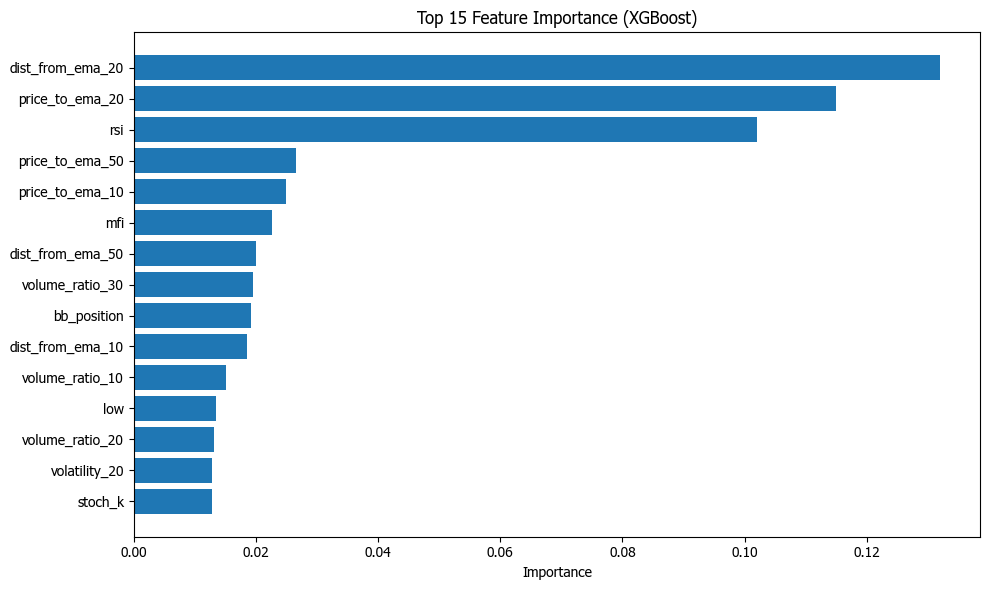

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Accum', 'Dist'],
    yticklabels=['Normal', 'Accum', 'Dist']
)
plt.title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 15 MOST IMPORTANT FEATURES")
display(feature_importance.head(15))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(15)['feature'][::-1], feature_importance.head(15)['importance'][::-1])
plt.title("Top 15 Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


✅ (Optional) เพิ่ม Cell Dashboard Wyckoff (เหมือนโค้ดคุณ)

📌 Optional Cell — Wyckoff Dashboard

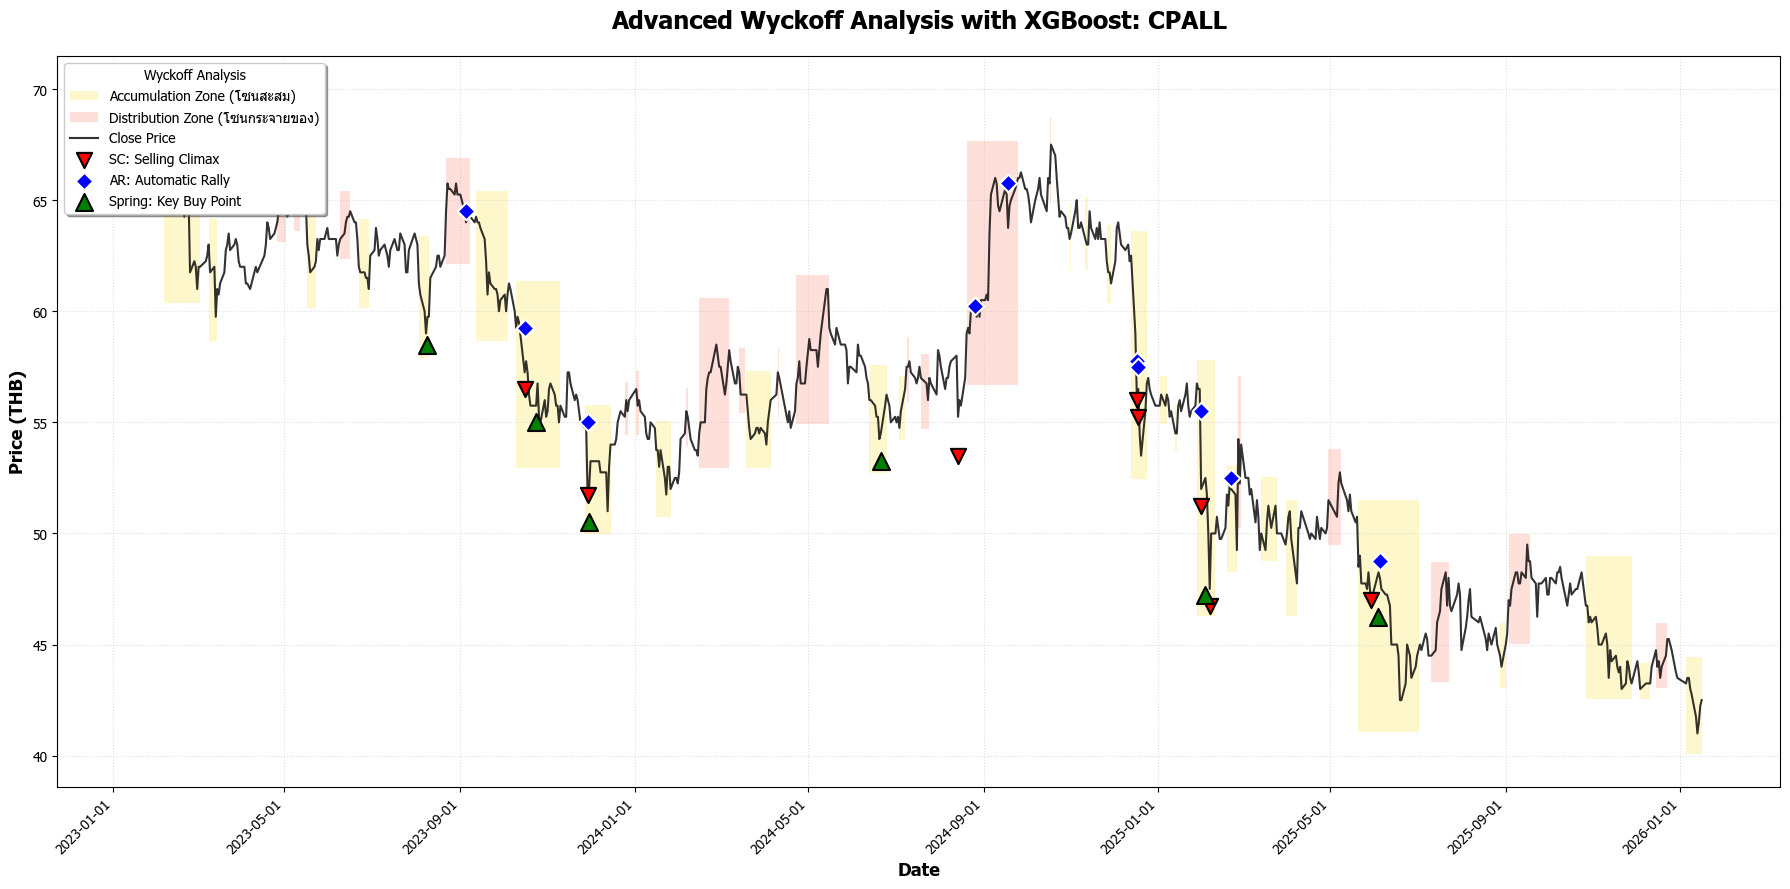

In [31]:
def plot_wyckoff_dashboard(df):
    plt.rcParams['font.family'] = 'Tahoma'
    plt.rcParams['axes.unicode_minus'] = False

    MAIN_TITLE = f"Advanced Wyckoff Analysis with XGBoost: {SYMBOL}"
    ACCUM_COLOR = '#FFD700'
    DIST_COLOR = '#FF6347'

    fig, ax = plt.subplots(figsize=(18, 9))

    zone_types = {
        1: (ACCUM_COLOR, 'Accumulation Zone (โซนสะสม)'),
        2: (DIST_COLOR, 'Distribution Zone (โซนกระจายของ)')
    }

    for zone_id, (color, label_name) in zone_types.items():
        subset = df[df['zone_pred'] == zone_id].copy()
        if len(subset) > 0:
            start_t = subset['time'].iloc[0]

            for i in range(1, len(subset)):
                time_gap = (subset['time'].iloc[i] - subset['time'].iloc[i-1]).days
                is_last = (i == len(subset) - 1)

                if time_gap > 5 or is_last:
                    end_t = subset['time'].iloc[i] if is_last else subset['time'].iloc[i-1]
                    box_data = df[(df['time'] >= start_t) & (df['time'] <= end_t)]

                    if len(box_data) > 0:
                        rect_start = mdates.date2num(start_t)
                        rect_width = mdates.date2num(end_t) - rect_start
                        y_min = box_data['low'].min() * 0.99
                        y_max = box_data['high'].max() * 1.01

                        rect = patches.Rectangle(
                            (rect_start, y_min), rect_width, y_max - y_min,
                            linewidth=0, facecolor=color, alpha=0.2,
                            label=label_name, zorder=1
                        )
                        ax.add_patch(rect)

                    start_t = subset['time'].iloc[i]

    ax.plot(df['time'], df['close'], 'k-', linewidth=1.5,
            label='Close Price', zorder=3, alpha=0.8)

    for event, marker, color, size, label in [
        ('SC', 'v', 'red', 120, 'SC: Selling Climax'),
        ('AR', 'D', 'blue', 80, 'AR: Automatic Rally'),
        ('SPRING', '^', 'green', 150, 'Spring: Key Buy Point')
    ]:
        points = df[df[event]]
        if len(points) > 0:
            y_val = points['low'] if event in ['SC', 'SPRING'] else points['high']
            ax.scatter(points['time'], y_val, color=color, marker=marker, s=size,
                       edgecolor='black' if event != 'AR' else 'white',
                       linewidth=1.5, label=label, zorder=10)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45, ha='right')

    ax.set_title(MAIN_TITLE, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax.set_ylabel('Price (THB)', fontsize=13, fontweight='bold')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
              loc='upper left', fontsize=10, frameon=True, shadow=True,
              title="Wyckoff Analysis")

    ax.grid(True, linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_wyckoff_dashboard(df_labeled)
